In [ ]:
!pip install scikit-learn==1.0.2
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/STTM

/content/gdrive/MyDrive/STTM


In [ ]:
import sklearn
print(sklearn.__version__) #need to be 1.0.2

1.0.2


In [ ]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import datetime
import re
import time
import warnings
import csv
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from tqdm.notebook import tqdm
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve,roc_auc_score
import lightgbm as lgb
import xgboost as xgb
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import random as python_random
import tensorflow as tf
from keras import backend as K 
from tensorflow import keras


In [ ]:
%%capture
!pip install --quiet finetune
import finetune as ft

### Loading the data

In [ ]:
def get_labels_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict


def get_features_labels(root, labels_dict):
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        string = " "
        for message in conversation:
            text = message.find('text').text
            if text is not None:
                #preprocess:
                # text = preprocess_text(text)
                string = string + "\r\n" + text 
        corpus.append(string)
        labels.append(int(labels_dict[conversation.get('id')]))
    return corpus, labels

In [ ]:
train_data_path = "data/pan12-sexual-predator-identification-training-corpus-2012-05-01/"

training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = 'data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_path + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path))
test_corpus, test_labels = get_features_labels(test_root, get_labels_dict(test_data_path))

In [ ]:
from os import listdir
from os.path import isfile, join
import warnings
mypath = 'GeneralData'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.remove('chatlog.dtd')
corpus_pj = [] # each row is a string formed from all messages in a conversations
labels_pj = [] # each row is 0 or 1, corresponds to label for same row in corpus
for file in onlyfiles:
    df= pd.read_xml(f'GeneralData/{file}').drop(columns=['COMMENT'])
    df=df[~df['BODY'].isna()]
    df=df[~df['USERNAME'].isna()]
    string = " "
    for text in df.BODY.tolist():
        if text is not None:
            #preprocess:
            #preprocess:
            # text = preprocess_text(text)
            string = string + "\r\n" + text 
    corpus_pj.append(string)
    labels_pj.append(1)

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)
#transform it with TF-IDF based on the trained corpus
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)#[:,best_feat]
y_test_pj = np.array(labels_pj)

# Load all trained models

In [ ]:
modelgbm = pickle.load(open('lgbm.sav', 'rb'))# pickle.dump(modelgbm, open('lgbm.sav', 'wb')) # to load: loaded_model = pickle.load(open(filename, 'rb'))
model_b = pickle.load(open('xgb.sav', 'rb'))# pickle.dump(model_b, open('xgb.sav', 'wb'))
model_svc = pickle.load(open('svc.sav', 'rb'))# pickle.dump(model_svc, open('svc.sav', 'wb'))
eclf = pickle.load(open('voting.sav', 'rb'))# pickle.dump(eclf, open('voting.sav', 'wb'))
clf = pickle.load(open('stacking.sav', 'rb'))# pickle.dump(clf, open('stacking.sav', 'wb'))
modeldnn =  keras.models.load_model('dnn')
bertmodel = ft.Classifier.load('roberta')
txtcnn = ft.Classifier.load('txtcnn')

Downloading: roberta-model-sm-v2.jl


100%|██████████| 328M/328M [00:24<00:00, 13.6MiB/s]


Downloading: dict.txt


100%|██████████| 603k/603k [00:00<00:00, 682kiB/s]


Downloading: roberta_vocab.bpe


100%|██████████| 456k/456k [00:00<00:00, 635kiB/s]


Downloading: roberta_encoder.json


100%|██████████| 899k/899k [00:00<00:00, 996kiB/s]


Downloading: encoder.json


100%|██████████| 1.04M/1.04M [00:00<00:00, 1.15MiB/s]


Downloading: vocab.bpe


100%|██████████| 456k/456k [00:00<00:00, 634kiB/s]


Downloading: model-sm.jl


100%|██████████| 655M/655M [00:42<00:00, 15.3MiB/s]


In [ ]:
y_pred_1 =  modelgbm.predict(X_test )
y_pred_2 =  model_b.predict(X_test )
y_pred_3 = model_svc.predict(X_test)
y_pred_4 = eclf.predict(X_test)
y_pred_5 = clf.predict(X_test)
y_pred_6 = np.round(modeldnn.predict(X_test.astype('float16')).flatten())

# Confusion matrix

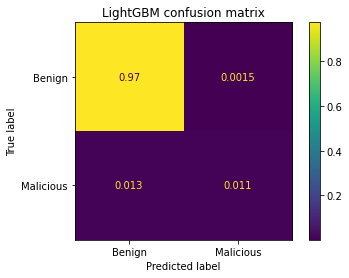

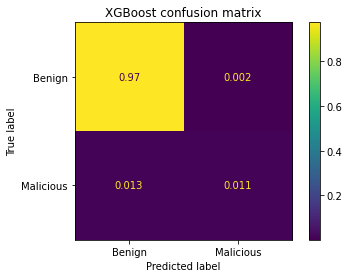

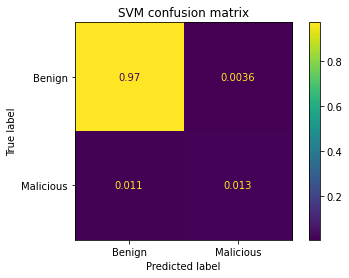

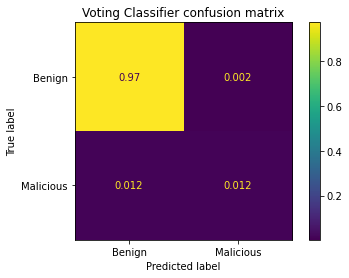

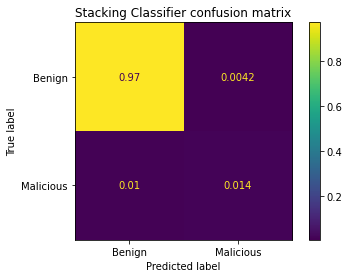

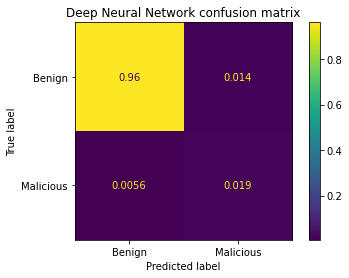

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
preds = [y_pred_1,y_pred_2,y_pred_3,y_pred_4,y_pred_5,y_pred_6]
mod_names= ['LightGBM','XGBoost','SVM','Voting Classifier','Stacking Classifier','Deep Neural Network']
for i,title in enumerate(mod_names):
  cm = confusion_matrix(y_test, preds[i], normalize='all')
  cmd = ConfusionMatrixDisplay(cm, display_labels=['Benign','Malicious'])
  cmd.plot()
  cmd.ax_.set_title(f"{mod_names[i]} confusion matrix")

#Zero False Negative policy Model

In [ ]:
from itertools import compress

In [ ]:
y_pred_phase_1 == False

array([ True, False,  True, ...,  True,  True,  True])

In [ ]:
pred_phase1_ind = np.where(y_pred_phase_1)[0]
benign_ind = np.where(y_pred_phase_1 == False)[0]


In [ ]:
preds_zfn = np.zeros(X_test.shape[0])
t = time.time()
y_pred_phase_1 =  modelgbm.predict(X_test)
#save indices
pred_phase1_ind = np.where(y_pred_phase_1)[0]
benign_ind = np.where(y_pred_phase_1 == False)[0]
mask = y_pred_phase_1 == False
test_c = list(compress(test_corpus, mask))
y_pred_phase_2 =bertmodel.predict(test_c)
preds_zfn[pred_phase1_ind] = 1
preds_zfn[benign_ind] = y_pred_phase_2
zfn_model_time = (time.time() - t)/60

In [ ]:
metrics.accuracy_score(y_test,preds_zfn)*100 , zfn_model_time 

---

#F1 score

In [ ]:
%%time
F1_1=  metrics.f1_score(y_test, modelgbm.predict(X_test))*100

F1_2=  metrics.f1_score(y_test, model_b.predict(X_test))*100

F1_3=  metrics.f1_score(y_test, model_svc.predict(X_test))*100

F1_4=  metrics.f1_score(y_test, eclf.predict(X_test))*100

F1_5=  metrics.f1_score(y_test, clf.predict(X_test))*100

F1_6=  metrics.f1_score(y_test, np.round(modeldnn.predict(X_test.astype('float16')).flatten()))*100


CPU times: user 3min 47s, sys: 2.51 s, total: 3min 50s
Wall time: 3min 28s


In [ ]:
F1_1,F1_2,F1_3,F1_4,F1_5,F1_6

(61.6214335421016,
 60.61023961385968,
 64.88441578864601,
 64.52476572958501,
 65.23605150214593,
 65.41353383458647)

In [ ]:
y_pred_bert = bertmodel.predict(test_corpus)
F1_7 = metrics.f1_score(test_labels,y_pred_bert)*100


Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:818: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:827: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:836: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.D

In [ ]:
y_pred_txtcnn = txtcnn.predict(test_corpus)
F1_8  = metrics.f1_score(test_labels, y_pred_txtcnn)*100 #textcnn


Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/textcnn/featurizer.py:77: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  kernel_initializer=tf.compat.v1.initializers.glorot_normal,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:294: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
Inference: 155418it [23:08, 111.92it/s]


In [ ]:
F1_list = ['F1_Score',F1_1,F1_2,F1_3,F1_4,F1_5,F1_6,F1_7,F1_8]
with open('F1_list.pkl', 'wb') as f:
  pickle.dump(F1_list, f)
f.close()

In [ ]:
%%capture
### save accuracy on pj dataset

acc1_pj=  metrics.accuracy_score(y_test_pj, modelgbm.predict(X_test_pj ))*100

acc2_pj=  metrics.accuracy_score(y_test_pj, model_b.predict(X_test_pj))*100

acc3_pj=  metrics.accuracy_score(y_test_pj, model_svc.predict(X_test_pj))*100

acc4_pj=  metrics.accuracy_score(y_test_pj, eclf.predict(X_test_pj))*100

acc5_pj=  metrics.accuracy_score(y_test_pj, clf.predict(X_test_pj))*100

acc6_pj=  metrics.accuracy_score(y_test_pj, np.round(modeldnn.predict(X_test_pj.astype('float16')).flatten()))*100

y_pred_bert = bertmodel.predict(corpus_pj)
acc7_pj = metrics.accuracy_score(labels_pj,y_pred_bert)*100

y_pred_txtcnn = txtcnn.predict(corpus_pj)
acc8_pj  = metrics.accuracy_score(labels_pj, y_pred_txtcnn)*100 #textcnn

acc_pj = ['PervJust Accuracy',acc1_pj,acc2_pj,acc3_pj,acc4_pj,acc5_pj,acc6_pj,acc7_pj,acc8_pj]

In [ ]:
len(labels_pj)

56

In [ ]:
%%time
inf_time_list = ['Inference Time [Min]']
t = time.time()
acc1=  metrics.accuracy_score(y_test, modelgbm.predict(X_test))*100
inf_time_list.append((time.time() - t)/60)

t = time.time()
acc2=  metrics.accuracy_score(y_test, model_b.predict(X_test))*100
inf_time_list.append((time.time() - t)/60)

t = time.time()
acc3=  metrics.accuracy_score(y_test, model_svc.predict(X_test))*100
inf_time_list.append((time.time() - t)/60)

t = time.time()
acc4=  metrics.accuracy_score(y_test, eclf.predict(X_test))*100
inf_time_list.append((time.time() - t)/60)

t = time.time()
acc5=  metrics.accuracy_score(y_test, clf.predict(X_test))*100
inf_time_list.append((time.time() - t)/60)

t = time.time()
acc6=  metrics.accuracy_score(y_test, np.round(modeldnn.predict(X_test.astype('float16')).flatten()))*100
inf_time_list.append((time.time() - t)/60)


CPU times: user 3min 53s, sys: 3.12 s, total: 3min 56s
Wall time: 3min 30s


In [ ]:
t = time.time()
y_pred_bert = bertmodel.predict(test_corpus)
acc7 = metrics.accuracy_score(test_labels,y_pred_bert)*100
inf_time_list.append((time.time() - t)/60)


Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:818: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:827: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:836: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.D

In [ ]:
t = time.time()
y_pred_txtcnn = txtcnn.predict(test_corpus)
acc8  = metrics.accuracy_score(test_labels, y_pred_txtcnn)*100 #textcnn
inf_time_list.append((time.time() - t)/60)

Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/textcnn/featurizer.py:77: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  kernel_initializer=tf.compat.v1.initializers.glorot_normal,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:294: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
Inference: 155418it [28:32, 90.76it/s]


In [ ]:
with open('inf_time_list.pkl', 'wb') as f:
  pickle.dump(inf_time_list, f)
f.close()
accuracy_list = ['Accuracy',acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8]
with open('accuracy_list.pkl', 'wb') as f:
  pickle.dump(accuracy_list, f)
f.close()
with open('acc_pj.pkl', 'wb') as f:
  pickle.dump(acc_pj, f)
f.close()

In [ ]:
inf_time_list =pickle.load(open('inf_time_list.pkl', 'rb'))
accuracy_list = pickle.load(open('accuracy_list.pkl', 'rb'))
acc_pj = pickle.load(open('acc_pj.pkl', 'rb'))

In [ ]:
y_pred_prob1 = modelgbm.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)
auc1 = roc_auc_score(y_test, y_pred_prob1)

y_pred_prob2 = model_b.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)
auc2 = roc_auc_score(y_test, y_pred_prob2)


y_pred_prob3 = model_svc.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 =  roc_curve(y_test, y_pred_prob3)
auc3 = roc_auc_score(y_test, y_pred_prob3)

y_pred_prob4 = eclf.predict_proba(X_test)[:,1] 
fpr4 , tpr4, thresholds4 =  roc_curve(y_test, y_pred_prob4)
auc4 = roc_auc_score(y_test, y_pred_prob4)


y_pred_prob5 = clf.predict_proba(X_test)[:,1]
fpr5 , tpr5, thresholds5 =  roc_curve(y_test, y_pred_prob5)
auc5 = roc_auc_score(y_test, y_pred_prob5)

y_pred_prob6 = (modeldnn.predict(X_test)).flatten()
fpr6 , tpr6, thresholds6 =  roc_curve(y_test, y_pred_prob6)
auc6 = roc_auc_score(y_test, y_pred_prob6)

y_pred_prob7 = bertmodel.predict_proba(test_corpus)
y_pred_prob7 = [val[1] for val in y_pred_prob7]
fpr7 , tpr7, thresholds7 =  roc_curve(test_labels, y_pred_prob7)
auc7 = roc_auc_score(test_labels, y_pred_prob7)



tpf_fpr_auc =[(fpr1 , tpr1,auc1)]

Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:818: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:827: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:836: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.D

In [ ]:
tpf_fpr_auc =[(fpr1 , tpr1,auc1),(fpr2 , tpr2,auc2),(fpr3 , tpr3,auc3),(fpr4 , tpr4,auc4),(fpr5 , tpr5,auc5),(fpr6 , tpr6,auc6),(fpr7 , tpr7,auc7)]

In [ ]:
with open('tpf_fpr_auc_1_7.pkl', 'wb') as f:
  pickle.dump(tpf_fpr_auc , f)
f.close()

In [ ]:
tpf_fpr_auc=   pickle.load(open('tpf_fpr_auc_1_7.pkl', 'rb'))

In [ ]:
txtcnn = ft.Classifier.load('txtcnn')

In [ ]:
y_pred_prob8 = txtcnn.predict_proba(test_corpus)
y_pred_prob8 = [val[1] for val in y_pred_prob8]
fpr8 , tpr8, thresholds8 =  roc_curve(test_labels, y_pred_prob8)
auc8 = roc_auc_score(test_labels, y_pred_prob8)

Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/textcnn/featurizer.py:77: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  kernel_initializer=tf.compat.v1.initializers.glorot_normal,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:294: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
Inference: 155418it [30:50, 83.97it/s]


In [ ]:
tpf_fpr_auc.append((fpr8 , tpr8,auc8))
with open('tpf_fpr_auc_1_8.pkl', 'wb') as f:
  pickle.dump(tpf_fpr_auc , f)
f.close()

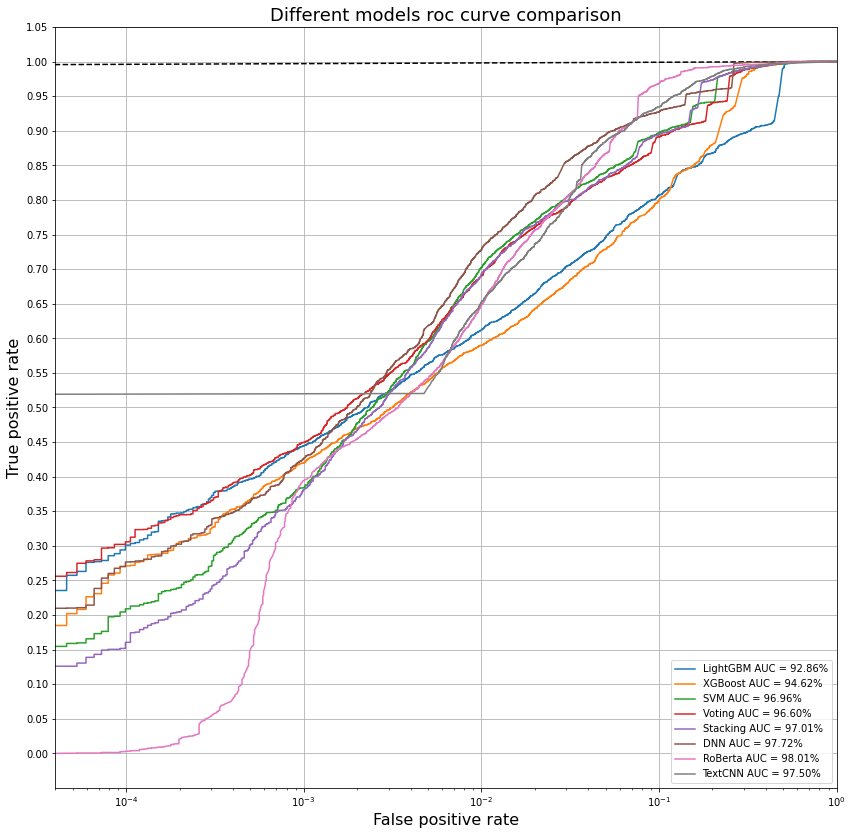

In [ ]:
# tpf_fpr_auc =[(fpr1 , tpr1,auc1)
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(14) # set height
plt.plot([0,1],[0,1], 'k--')
plt.plot(tpf_fpr_auc[0][0], tpf_fpr_auc[0][1], label= f"LightGBM AUC = {100*tpf_fpr_auc[0][2] :.2f}%")
plt.plot(tpf_fpr_auc[1][0], tpf_fpr_auc[1][1], label= f"XGBoost AUC = {100*tpf_fpr_auc[1][2] :.2f}%")
plt.plot(tpf_fpr_auc[2][0], tpf_fpr_auc[2][1], label= f"SVM AUC = {100*tpf_fpr_auc[2][2] :.2f}%")
plt.plot(tpf_fpr_auc[3][0], tpf_fpr_auc[3][1], label= f"Voting AUC = {100*tpf_fpr_auc[3][2] :.2f}%")
plt.plot(tpf_fpr_auc[4][0], tpf_fpr_auc[4][1], label= f"Stacking AUC = {100*tpf_fpr_auc[4][2] :.2f}%")
plt.plot(tpf_fpr_auc[5][0], tpf_fpr_auc[5][1], label= f"DNN AUC = {100*tpf_fpr_auc[5][2] :.2f}%")
plt.plot(tpf_fpr_auc[6][0], tpf_fpr_auc[6][1], label= f"RoBerta AUC = {100*tpf_fpr_auc[6][2] :.2f}%")
plt.plot(tpf_fpr_auc[7][0], tpf_fpr_auc[7][1], label= f"TextCNN AUC = {100*tpf_fpr_auc[7][2] :.2f}%")
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.gca().grid(True)
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate",fontsize=16)
plt.title('Different models roc curve comparison',fontsize=18)
plt.legend(loc= 'lower right')
plt.show()

# Accuracy and detection rates

In [ ]:
tpf_fpr_auc=   pickle.load(open('tpf_fpr_auc_1_8.pkl', 'rb'))

In [ ]:
dat=pd.DataFrame(data= [accuracy_list,F1_list,
                        ['AUC',tpf_fpr_auc[0][2]*100,tpf_fpr_auc[1][2]*100,tpf_fpr_auc[2][2]*100,tpf_fpr_auc[3][2]*100,tpf_fpr_auc[4][2]*100,tpf_fpr_auc[5][2]*100,tpf_fpr_auc[6][2]*100,tpf_fpr_auc[7][2]*100],
                        ['0.1% FPR Detection',
                        tpf_fpr_auc[0][1][np.abs(tpf_fpr_auc[0][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[1][1][np.abs(tpf_fpr_auc[1][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[2][1][np.abs(tpf_fpr_auc[2][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[3][1][np.abs(tpf_fpr_auc[3][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[4][1][np.abs(tpf_fpr_auc[4][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[5][1][np.abs(tpf_fpr_auc[5][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[6][1][np.abs(tpf_fpr_auc[6][0]-0.001).argmin()] * 100,
                        tpf_fpr_auc[7][1][1] * 100
                         ],
                        ['1% FPR Detection',
                        tpf_fpr_auc[0][1][np.abs(tpf_fpr_auc[0][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[1][1][np.abs(tpf_fpr_auc[1][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[2][1][np.abs(tpf_fpr_auc[2][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[3][1][np.abs(tpf_fpr_auc[3][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[4][1][np.abs(tpf_fpr_auc[4][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[5][1][np.abs(tpf_fpr_auc[5][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[6][1][np.abs(tpf_fpr_auc[6][0]-0.01).argmin()] * 100,
                        tpf_fpr_auc[7][1][np.abs(tpf_fpr_auc[7][0]-0.01).argmin()] * 100
                         ],
                        inf_time_list,
                        acc_pj],
                 columns =  ['metric','LightGBM','XGBoost','SVM','Voting','Stacking','DNN','RoBerta','TextCNN'])
dat = dat.set_index('metric')
dat = dat.rename(index={'Accuracy': 'Accuracy on PAN12 test'})

In [ ]:
dat.round(2)

,LightGBM,XGBoost,SVM,Voting,Stacking,DNN,RoBerta,TextCNN
metric,,,,,,,,
Accuracy on PAN12 test,98.58,98.53,98.56,98.63,98.54,98.04,98.12,98.14
F1_Score,61.62,60.61,64.88,64.52,65.24,65.41,63.16,63.17
AUC,92.86,94.62,96.96,96.60,97.01,97.72,98.01,97.50
0.1% FPR Detection,44.45,41.96,38.37,44.93,38.05,42.57,39.44,52.02
1% FPR Detection,61.17,58.98,70.22,69.01,69.23,72.73,64.76,65.16
Inference Time [Min],0.03,0.04,1.07,1.07,1.10,0.20,53.52,28.55
PervJust Accuracy,98.21,96.43,96.43,98.21,98.21,98.21,100.00,100.00


In [ ]:
dat

,LightGBM,XGBoost,SVM,Voting,Stacking,DNN,RoBerta,TextCNN
metric,,,,,,,,
Accuracy on PAN12 test,98.577949,98.527023,98.560544,98.633387,98.537982,98.042907,98.119617,98.142179
AUC,92.859180,94.617247,96.964653,96.599648,97.010754,97.720805,98.014320,97.500983
0.1% FPR Detection,44.447418,41.958790,38.373026,44.929088,38.051913,42.574257,39.443404,52.020337
1% FPR Detection,61.172063,58.977790,70.216751,69.012577,69.226652,72.732138,64.757827,65.159219
Inference Time [Min],0.030517,0.042152,1.074676,1.065741,1.096766,0.198748,53.517760,28.547093
PervJust Accuracy,98.214286,96.428571,96.428571,98.214286,98.214286,98.214286,100.000000,100.000000


In [ ]:
dat.to_csv('results_df.csv')

In [ ]:
F1_list

['F1_Score',
 61.6214335421016,
 60.61023961385968,
 64.88441578864601,
 64.52476572958501,
 65.23605150214593,
 65.41353383458647,
 63.16454097739614,
 63.17403526705853]